# Interactive Wavefront notebook

## display a wavefront map and a geometrical PSF

## use ipywidget sliders to control the amount of tilt and defocus to apply to the wavefront.

## uses a paraboloidal reflector as an example

In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *

from rayoptics.gui import dashboards
import matplotlib.colors as mcolors
import ipywidgets as widgets

# Create a new model

In [3]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

## Define first order aperture and field for system

In [4]:
pupil_diameter = 100.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'epd'], value=pupil_diameter)

# 1 mrad half FOV
max_fov = math.degrees(.001)
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], value=max_fov, flds=[0.0, 1.0], is_relative=True)

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([(550.0, 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [5]:
sm.gaps[0].thi = 1e+11

In [6]:
#opm.add_mirror(lbl='M1', r=-500., t=-250.)
opm.add_mirror(lbl='M1', profile=Conic, r=-500., cc=-1., t=-250.)

In [7]:
opm.update_model()
fod = ar['parax_data'].fod

# List first order data

In [8]:
pm.first_order_data()

efl                -250
f                   250
f'                 -250
ffl                -250
pp1                   0
bfl                -250
ppk                  -0
pp sep                0
f/#                 2.5
m              -2.5e-09
red              -4e+08
obj_dist          1e+11
obj_ang          0.0573
enp_dist             -0
enp_radius           50
na obj            5e-10
n obj                 1
img_dist           -250
img_ht             0.25
exp_dist      -6.25e-07
exp_radius           50
na img              0.2
n img                -1
optical invariant         0.05


In [9]:
fod.img_na

0.1999999995

In [10]:
opd = 0.25*opm.nm_to_sys_units(osp.spectral_region.central_wvl)
dfoc = opd/(fod.img_na**2/(2*fod.n_img)); dfoc

-0.006875000034374999

In [11]:
fod.img_na**2

0.0399999998

# Draw a lens picture

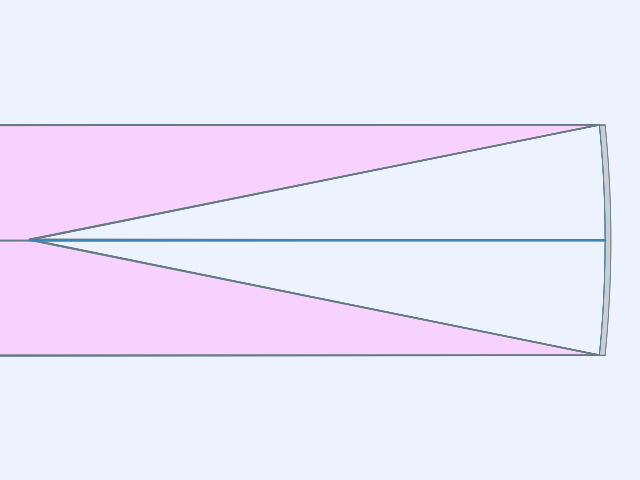

In [12]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False).plot()

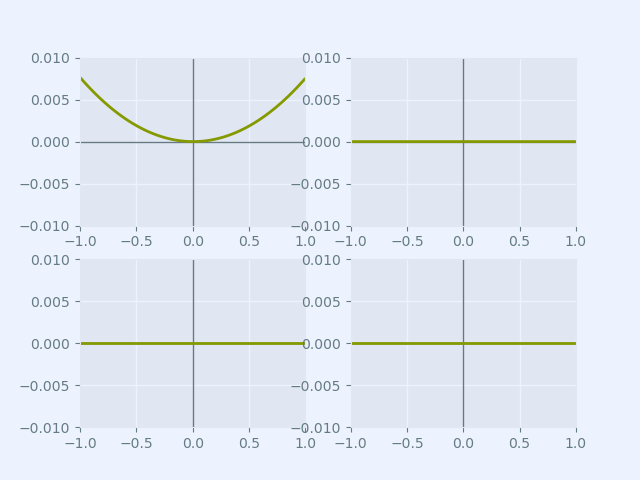

In [13]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray', scale_type=Fit.User_Scale, user_scale_value=.01).plot()

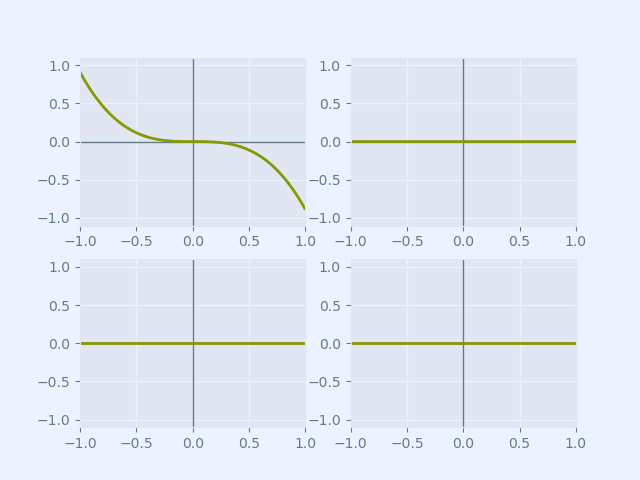

In [14]:
wav_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='OPD', scale_type=Fit.User_Scale, user_scale_value=1.1).plot()

## Setup dashboard for edge of field

In [15]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(1)

### calculate some useful scaling factors

In [16]:
opd = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = opd/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)
# one wave of tilt
image_pt, ref_dir, ref_sphere_radius, lcl_tfrm_last = fld.ref_sphere
shft = ref_sphere_radius*opd/fod.exp_radius

### setup ray_grid and ray_list to supply data for the analyses

In [17]:
ctr_ray = trace_base(opm, [0., 0.], fld, wvl)
img_offset = ctr_ray[0][-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

num_rays=21
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl)

r2g = (sampler.create_generator, (sampler.R_2_quasi_random_generator, num_rays**2),
       dict(mapper=sampler.concentric_sample_disk))
ray_list = analyses.RayList(opm, pupil_gen=r2g, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

### Create the interactive display

- create the Wavefront and RayGeoPSF plotting objects
- embed them in an AnalysisFigure
- create the notebook widgets to control defocus and tilt
- display the figure and the widgets

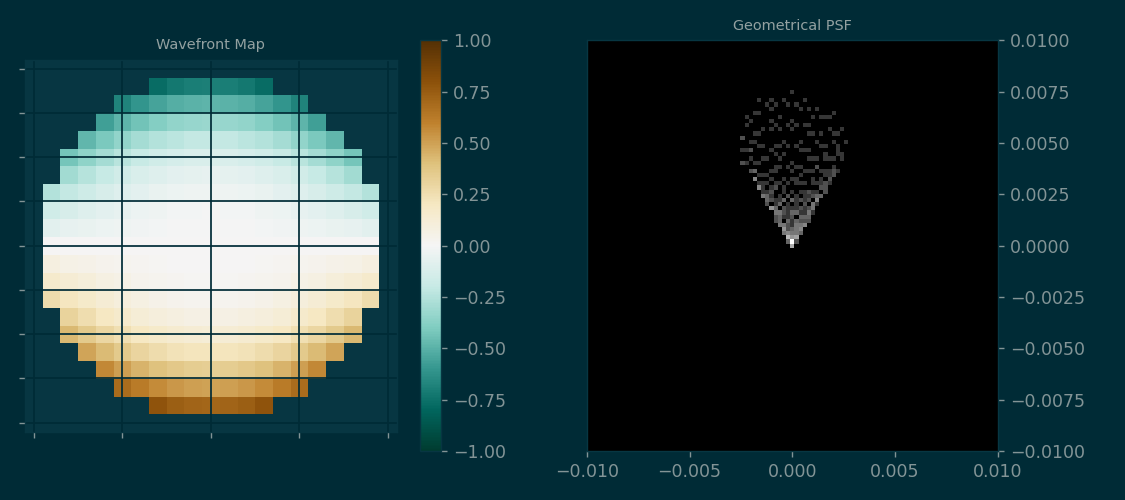

In [18]:
wfr = Wavefront(ray_grid, user_scale_value=1.0, do_contours=False,
                title='Wavefront Map', cmap="BrBG_r")

us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d', gamma=1./1.8,
                 title='Geometrical PSF', yaxis_ticks_position='right', #norm=scaler, vmax=80,
                 cmap='gray')

wvfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list], subplots=[wfr, gPSF],
                   grid=(1, 2), figsize=[9, 4], dpi=125, tight_layout=True, is_dark=True)

image_defocus = ray_grid.foc
image_delta = ray_grid.image_delta
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([wvfig], [ray_grid, ray_list],
                                                              image_defocus, abs(dfoc), 
                                                              shft, image_delta)
wvfig_out = wvfig.plot()

In [19]:
display(widgets.HBox([defocus, y_shift]))

### Draw the final wavefront using contour output

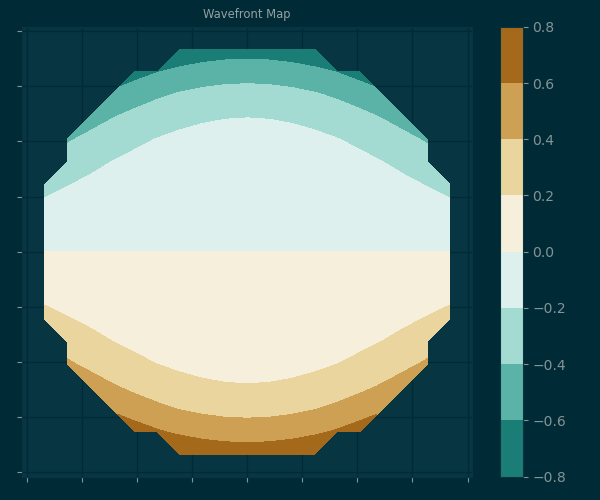

In [20]:
wfr = Wavefront(ray_grid, user_scale_value=1.0, do_contours=True,
                title='Wavefront Map', cmap="BrBG_r")
wvfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid],subplots=[wfr],
                   figsize=[6, 5], tight_layout=True, is_dark=True).plot()